In [1]:
import csv
import os
import warnings
from glob import glob

import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import regex as re
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa as smt
import xarray as xr
import yaml
from climix.metadata import load_metadata
from dask.distributed import Client
from tqdm.autonotebook import tqdm

/tmp/ipykernel_15959/1607831901.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Fetch station data

In [2]:
with open("./scripts/merges.yml") as file:
    merges_dict = yaml.safe_load(file)
with open("./scripts/long_stations_2.yml") as file:
    stations_to_use = yaml.safe_load(file)

In [3]:
list(stations_to_use.keys())

['Halmstad flygplats',
 'Kristianstad',
 'Karlshamn',
 'Växjö A',
 'Kalmar flygplats',
 'Göteborg A',
 'Jönköping-Axamos Flygplats',
 'Gladhammar A',
 'Visby Flygplats',
 'Vänersborg',
 'Skara',
 'Linköping-Malmslätt',
 'Örebro Flygplats',
 'Uppsala Aut',
 'Stockholm-Observatoriekullen A',
 'Gävle A',
 'Delsbo A',
 'Sveg A',
 'Härnösand',
 'Östersund-Frösön Flygplats',
 'Umeå Flygplats',
 'Piteå',
 'Haparanda A',
 'Jokkmokk Flygplats']

In [4]:
ids = [id for key in stations_to_use.keys() for id in merges_dict[key]["to_merge"]]

In [5]:
ids = list(set(ids))

In [6]:
from scripts.fetch_station_data import fetch_data, generate_filename

In [7]:
param = 4
stat_id = 3
from_date = "1881-01-01T00:00:00"
to_date = "2022-12-31T23:59:59"
output = "/nobackup/rossby27/users/sm_erhol/station_attribution_article/station_data/raw/tasmax/"

urls = [
    f"http://mora-apps.smhi.se/moraws/ws/value/v2/stationType/clim/stationId/{id}/parameter/{param}/statisticsFormula/{stat_id}/samplingTime/P1D/from/{from_date}/to/{to_date}?format=csv"
    for id in ids
]

In [8]:
fetch_data(urls, output)

  0%|          | 0/54 [00:00<?, ?it/s]

Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data already available, skipping
Data alrea

In [9]:
client = Client()

In [10]:
import iris_utils.preprocessing

In [11]:
from importlib import reload

In [12]:
reload(iris_utils.preprocessing)

<module 'iris_utils.preprocessing' from '/home/sm_erhol/dev/iris_utils/iris_utils/preprocessing.py'>

In [13]:
to_end = "2999-12-31 00:00:00"
cubes = []
for key in tqdm(stations_to_use.keys()):
    # Get values from the merges dict.
    stations = merges_dict[key]
    dfs = []
    for period_start, vals in stations["periods"].items():
        id = vals["id"]
        period_end = vals["to"] if vals["to"] != to_end else None
        file = glob(f"{output}{id}_*")[0]
        # Load
        dfs.append(iris_utils.preprocessing.load_df(file).loc[period_start:period_end])
    merged_df = pd.concat(dfs).sort_index()
    # merged_df = merged_df.drop_duplicates("Time", keep="first")
    merged_df.attrs = dfs[0].attrs
    merged_df.attrs["station_name"] = key

    cubes.append(iris_utils.preprocessing.cube_from_mora_df(merged_df))

  0%|          | 0/24 [00:00<?, ?it/s]

## Selection
Select cubes that match certain criteria?

In [14]:
# lon_cons = iris.Constraint(longitude=lambda x: x >= 13.5)
lat_cons = iris.Constraint(latitude=lambda x: x <= 60.0)
constraint = lat_cons

In [15]:
cubes_sel = [
    cube.extract(constraint) for cube in cubes if cube.extract(constraint) is not None
]

In [16]:
import scripts.plots

In [17]:
# scripts.plots.plot_stations(cubes_sel, extent=(11, 20, 52, 60))

## Pre-check
Before calculating the index we should check that there are enough observations in any given summer.
For this we need a categorical value for the summer months and then check the number of days in each summer.

In [18]:
import iris.coord_categorisation

In [19]:
fautly_stations = {}
for cube in tqdm(cubes_sel):
    try:
        iris.coord_categorisation.add_season_membership(cube, "time", "mjja")
    except ValueError:
        pass
    try:
        iris.coord_categorisation.add_year(cube, "time")
    except ValueError:
        pass
    constraint = iris.Constraint(coord_values={"season_membership": True})
    selection = cube.extract(constraint)
    count_valid = selection.aggregated_by(
        "year", iris.analysis.COUNT, function=lambda x: np.isreal(x)
    )
    mask = count_valid.data < 123
    years = count_valid.coord("year").points[mask]
    missing_days = (123 - count_valid.data[mask]) / 123
    fautly_stations[cube.attributes["station_name"]] = {
        key: value for key, value in zip(years, missing_days)
    }

  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
faulty_stations_df = pd.DataFrame(fautly_stations)
faulty_stations_df = faulty_stations_df.sort_index()

In [21]:
# faulty_stations_df

In [22]:
def check_station(station_name: str, threshold: float = 0.15) -> bool:
    if station_name not in faulty_stations_df.columns.values:
        return False
    else:
        hist_check = (
            faulty_stations_df[station_name][
                (faulty_stations_df.index >= 1882) & (faulty_stations_df.index <= 1911)
            ]
            >= threshold
        )
        curr_check = (
            faulty_stations_df[station_name][
                (faulty_stations_df.index >= 1989) & (faulty_stations_df.index <= 2018)
            ]
            >= threshold
        )
        return np.any(hist_check), np.any(curr_check)

## Saving cubes

Does not work for some reasons.

In [23]:
# for cube in cubes:
#     id = stations_to_use[cube.attributes["station_name"]]
#     first_date = cube.coord("time").cell(0).point.strftime("%Y-%m-%d")
#     last_date = cube.coord("time").cell(-1).point.strftime("%Y-%m-%d")
#     out_dir = "/nobackup/rossby27/users/sm_erhol/station_attribution_article/station_data/cubes/"
#     name = f"{cube.var_name}_{id}_{first_date}_{last_date}.nc"
#     cube.data
#     iris.save(cube, os.path.join(out_dir, name))

## Calc index

In [23]:
index_catalog, _ = load_metadata(None)

In [24]:
index_name = "txge25"

In [25]:
index = index_catalog.prepare_indices([index_name], None)[0]

In [26]:
for cube in cubes:
    cube.data = cube.lazy_data()

In [27]:
index_cubes = []
for cube in tqdm(cubes_sel):
    print(cube.attributes["station_name"])
    try:
        index_cubes.append(index([cube], client))
    except ValueError:
        cube.remove_coord("year")
        index_cubes.append(index([cube], client))

  0%|          | 0/15 [00:00<?, ?it/s]

Halmstad flygplats


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Kristianstad


INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Karlshamn


INFO:distributed.core:Event loop was unresponsive in Nanny for 7.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Växjö A


INFO:distributed.core:Event loop was unresponsive in Nanny for 6.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Kalmar flygplats


INFO:distributed.core:Event loop was unresponsive in Nanny for 7.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Göteborg A


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Jönköping-Axamos Flygplats


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 6.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Gladhammar A


INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Visby Flygplats


INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Vänersborg


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Skara


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Linköping-Malmslätt


INFO:distributed.core:Event loop was unresponsive in Nanny for 8.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Örebro Flygplats


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Uppsala Aut


INFO:distributed.core:Event loop was unresponsive in Nanny for 4.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 7.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Stockholm-Observatoriekullen A


INFO:distributed.core:Event loop was unresponsive in Nanny for 7.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [28]:
hist_constraint = iris.Constraint(time=lambda cell: 1882 <= cell.point.year <= 1911)
curr_constraint = iris.Constraint(time=lambda cell: 1989 <= cell.point.year <= 2018)
hist_cubes = []
curr_cubes = []
for cube in index_cubes:
    hist_ok = (hist_cube := cube.extract(hist_constraint)) and hist_cube.shape == (30,)
    curr_ok = (curr_cube := cube.extract(curr_constraint)) and curr_cube.shape == (30,)
    if hist_ok and curr_ok:
        hist_cubes.append(hist_cube)
        curr_cubes.append(curr_cube)

## Save selected stations

In [30]:
# Hacky
with open("./scripts/station_info_precip.yml") as file:
    station_info = yaml.safe_load(file)
for cube in cubes_sel:
    lat = float(cube.coord("latitude").points[0])
    lon = float(cube.coord("longitude").points[0])
    name = cube.attributes["station_name"]
    try:
        station_info[name]["var"].append("tasmax")
    except:
        station_info[cube.attributes["station_name"]] = {
            "lat": lat,
            "lon": lon,
            "var": ["tasmax"],
        }
with open("./scripts/station_info_all_vars.yml", "w") as file:
    yaml.dump(station_info, stream=file, allow_unicode=True)

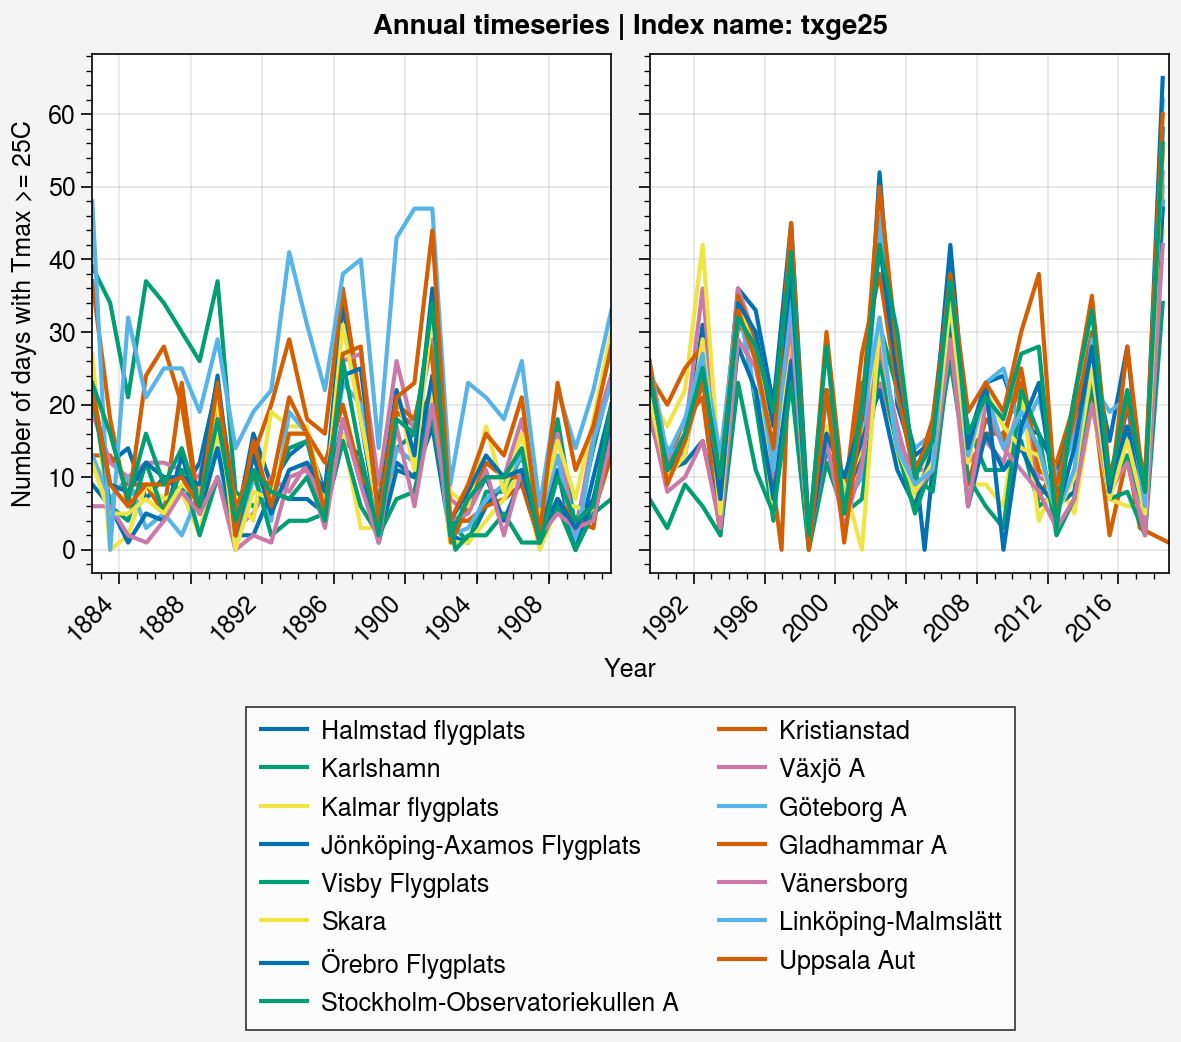

In [33]:
fig, axs = pplt.subplots(ncols=2, figwidth="15cm")
for hist_cube, curr_cube in zip(hist_cubes, curr_cubes):
    iplt.plot(hist_cube, axes=axs[0], label=hist_cube.attributes["station_name"])
    iplt.plot(curr_cube, axes=axs[1], label=curr_cube.attributes["station_name"])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="b")
ylabel = f"{hist_cube.long_name}"  # [{hist_cube.units}]"
axs.format(
    xlabel="Year",
    ylabel=ylabel,
    suptitle=f"Annual timeseries | Index name: {index_name}",
    xrotation=45,
)

In [29]:
dists = {"gumbel_r": stats.gumbel_r, "gev": stats.genextreme}

## Validating distributions

In [160]:
import attribution

{'gumbel_r': KstestResult(statistic=0.21338198318178148, pvalue=0.11189266605413661),
 'gev': KstestResult(statistic=0.1528072008411863, pvalue=0.4416744228197369)}

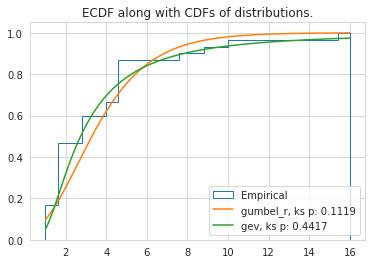

In [255]:
attribution.validation.inspect_distributions(hist_cubes[2].data, dists)

{'gumbel_r': KstestResult(statistic=0.10958394501879654, pvalue=0.826019606500246),
 'gev': KstestResult(statistic=0.12700338086131457, pvalue=0.671852069746989)}

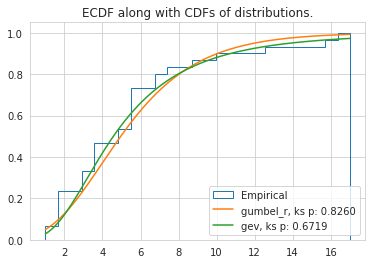

In [256]:
attribution.validation.inspect_distributions(curr_cubes[2].data, dists)

In [257]:
hist_fit = dists["gev"].fit(hist_cubes[2].data)
curr_fit = dists["gev"].fit(curr_cubes[2].data)

Simple check on plausibility.
Lower threshold should not return a higher FAR compared to higher thresholds.

In [259]:
p0 = dists["gev"].sf(10, *hist_fit)
p1 = dists["gev"].sf(10, *curr_fit)
1 - (p0 / p1)

0.4655940729758945

## Compute FAR and plot distributions

In [30]:
def fit_dist(hist_data, curr_data, dist):
    hist_fit = dist.fit(hist_data)
    curr_fit = dist.fit(curr_data)
    return hist_fit, curr_fit


def get_far(hist_fit, curr_fit, threshold, dist):
    p0 = dist.sf(threshold, *hist_fit)
    p1 = dist.sf(threshold, *curr_fit)
    return 1 - (p0 / p1)

In [31]:
rng = np.random.default_rng()

In [32]:
threshold = int(np.mean([cube[-1].data for cube in curr_cubes]))
print(threshold)

48


Bootstrap

In [33]:
from attribution.validation import select_distribution

In [34]:
dists = {"gumbel_r": stats.gumbel_r, "gev": stats.genextreme, "gamma": stats.gamma}

In [36]:
from pathos.pools import ProcessPool as Pool
from functools import partial

In [35]:
def pool_helper(curr_data, hist_data, dist, threshold_quantile):
    # curr_dist = select_distribution(curr_data, dists)
    # hist_dist = select_distribution(hist_data, dists)
    hist_fit, curr_fit = fit_dist(hist_data, curr_data, dist)
    threshold = dist.isf(threshold_quantile, *curr_fit)
    res = get_far(hist_fit, curr_fit, threshold, dist)
    return res

In [128]:
n_stations = len(hist_cubes)
n_samples = 1000
dist = dists["gumbel_r"]
far_res = np.zeros((n_stations, n_samples))
for i, (hist_cube, curr_cube) in tqdm(
    enumerate(zip(hist_cubes, curr_cubes)), total=n_stations
):
    # dist = attribution.validation.select_distribution(curr_cube.data, dists)
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    fit = dist.fit(curr_data)
    threshold_quantile = dist.sf(curr_data[-1], *fit)
    hist_resampled = rng.choice(hist_data, size=(n_samples, hist_data.shape[0]))
    curr_resampled = rng.choice(curr_data, size=(n_samples, hist_data.shape[0]))
    pool_helper_p =  partial(pool_helper, dist=dist, threshold_quantile=threshold_quantile)
    with Pool() as p:
        res = p.map(pool_helper_p, curr_resampled, hist_resampled)
    far_res[i] = res

  0%|          | 0/15 [00:00<?, ?it/s]

In [129]:
far_ci_q = np.quantile(far_res, [0.05, 0.5, 0.95], axis=1).T

In [130]:
far_ci_q

array([[ 8.95826467e-01,  9.87929854e-01,  9.99525043e-01],
       [-4.09014252e-02, -4.96931616e-03,  1.22152877e-01],
       [-5.31821318e+00, -6.42008467e-01,  7.30394374e-01],
       [-1.20099187e-01,  8.73928428e-01,  9.93694958e-01],
       [ 6.67864369e-01,  9.67446577e-01,  9.98514569e-01],
       [ 7.72201051e-01,  9.73480995e-01,  9.98156908e-01],
       [ 8.67791861e-01,  9.92287985e-01,  9.99861148e-01],
       [ 5.75784651e-01,  9.25699372e-01,  9.92894526e-01],
       [ 6.15760832e-01,  9.82959908e-01,  9.99762530e-01],
       [ 9.12427920e-01,  9.95295464e-01,  9.99946084e-01],
       [ 1.96014979e-01,  9.48805325e-01,  9.98309236e-01],
       [-1.42861721e+01, -3.41424478e+00,  3.74120792e-01],
       [ 8.79472098e-01,  9.93673174e-01,  9.99881980e-01],
       [ 5.32521541e-01,  9.33592714e-01,  9.95823622e-01],
       [ 8.93347145e-01,  9.89715253e-01,  9.99587593e-01]])

In [131]:
data = np.concatenate([cube.data for cube in hist_cubes + curr_cubes])
_, bins = np.histogram(data, bins=15)

In [132]:
threshold_name = "Summer 2018"

In [99]:
import math

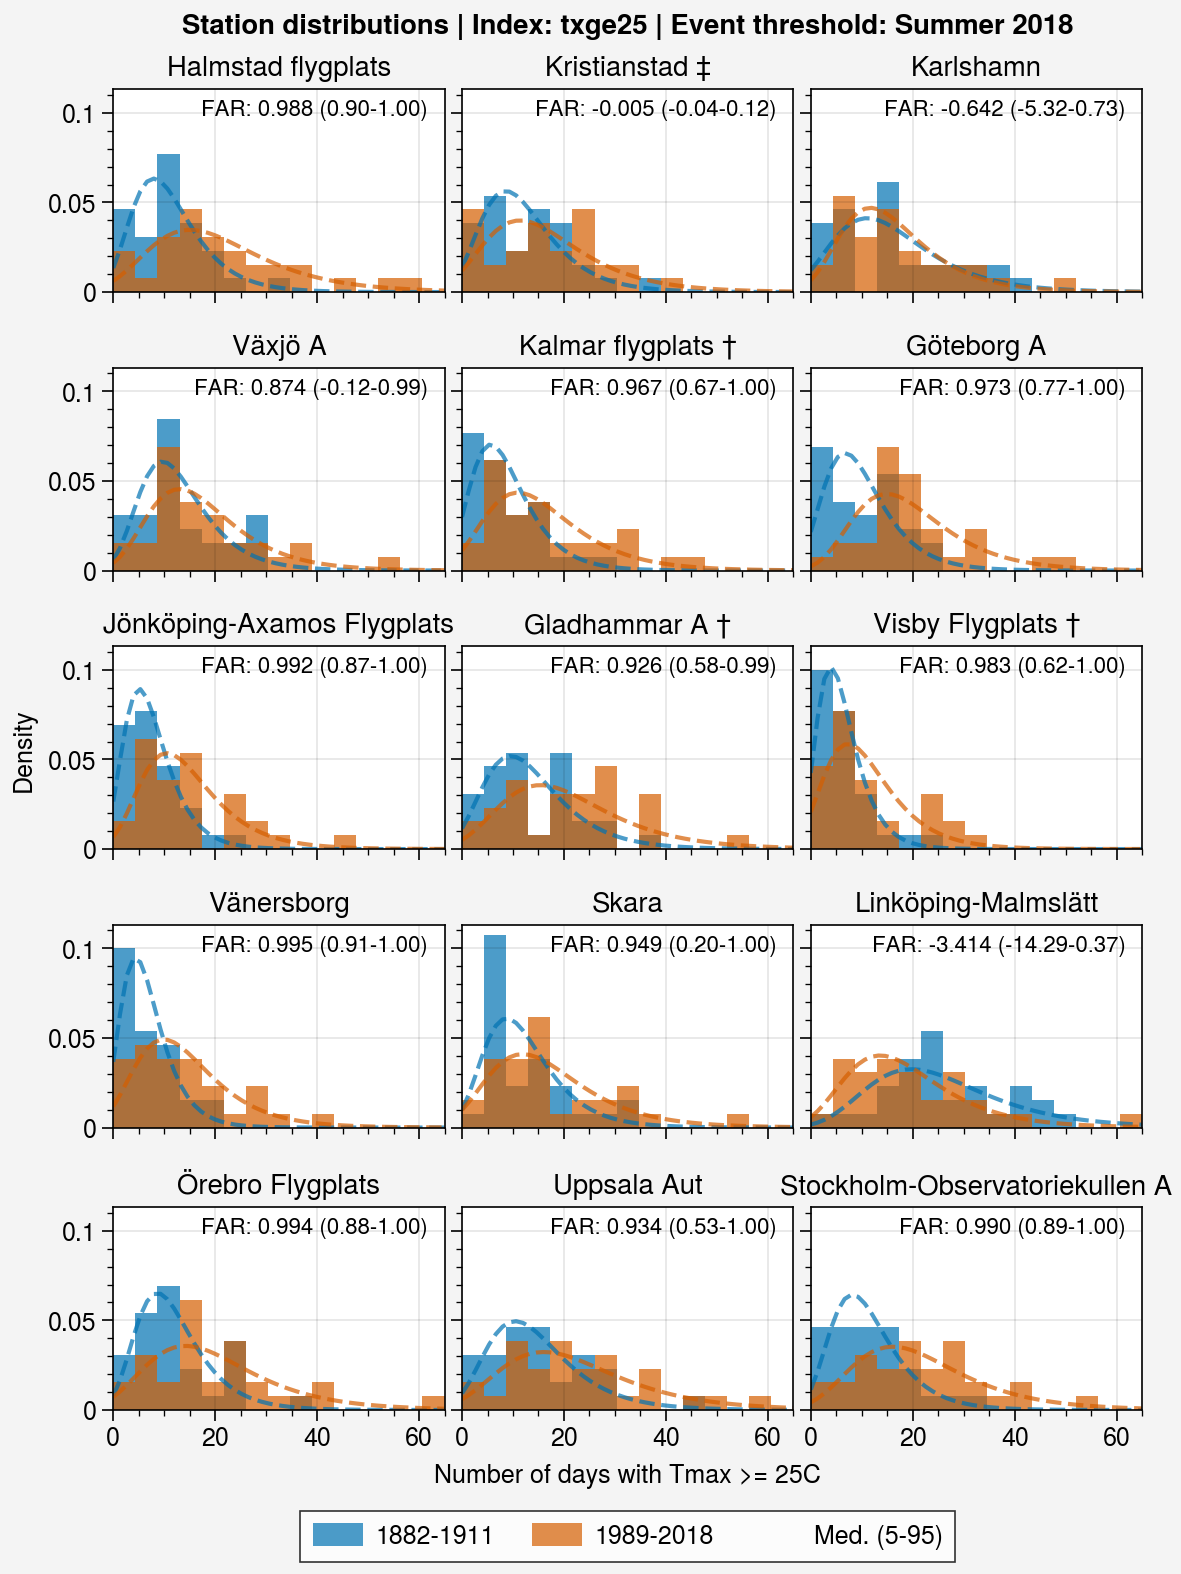

In [133]:
nrows = math.ceil(len(hist_cubes) / 3)
fig, axs = pplt.subplots(
    nrows=nrows,
    ncols=3,
    figwidth="15cm",
    figheight="20cm",
    wspace=0.7,
    sharex="all",
    sharey="all",
)
# axs_to_use = np.concatenate([axs.flat[:1], axs.flat[3:]])
axs_to_use = axs
for hist_cube, curr_cube, far_ci, ax in zip(
    hist_cubes, curr_cubes, far_ci_q, axs_to_use
):
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    ax.hist(hist_data, bins=bins, label="1882-1911", alpha=0.7, density=True)
    ax.hist(curr_data, bins=bins, label="1989-2018", alpha=0.7, density=True)
    dist = dists["gumbel_r"]
    hist_fit, curr_fit = fit_dist(hist_data, curr_data, dist)
    x = np.linspace(bins.min(), bins.max())
    ax.plot(x, dist.pdf(x, *hist_fit), c="C0", alpha=0.7, ls="--")
    ax.plot(x, dist.pdf(x, *curr_fit), c="C1", alpha=0.7, ls="--")

    title = hist_cube.attributes["station_name"]
    hist_check, curr_check = check_station(title)
    if hist_check:
        title += " †"
    if curr_check:
        title += " ‡"
    #
    ax.set_title(title)
    format_string = ".3g" if far_ci[0] < -1e2 else ".2f"
    ax.annotate(
        f"FAR: {far_ci[1]:.3f} ({far_ci[0]:{format_string}}-{far_ci[2]:.2f})",
        (0.95, 0.95),
        xycoords="axes fraction",
        va="top",
        ha="right",
        fontsize=8,
    )

# axs.flat[1].axis("off")
# axs.flat[2].axis("off")


long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
# Legend
axs[0].plot([], [], " ", label="Med. (5-95)")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=4, loc="b")
axs.format(
    ylabel="Density",
    xlabel=f"{long_name}",
    suptitle=f"Station distributions | Index: {index_name} | Event threshold: {threshold_name}",
)

In [134]:
fig.save(f"../plots/{index_name}_station_distributions_far.pdf")

Mini figure of factual/counter factual worlds

In [42]:
from textwrap import wrap

In [43]:
from matplotlib import patches

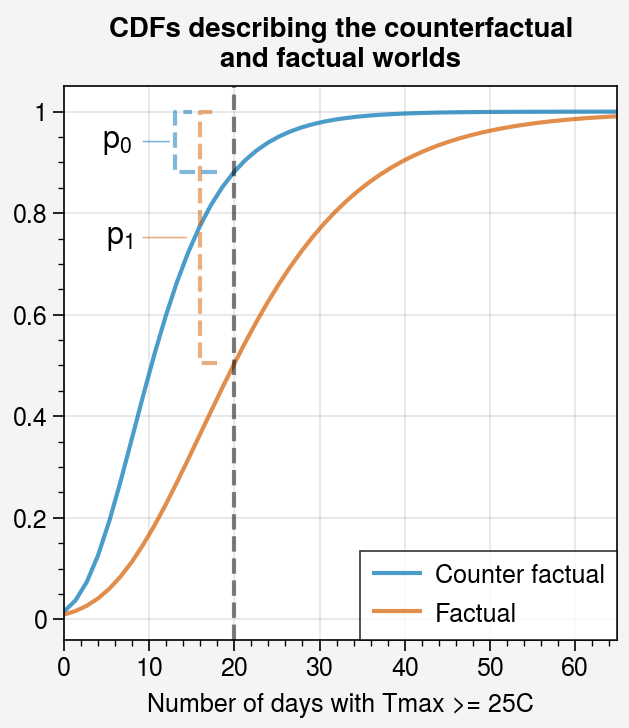

In [135]:
fig, ax = pplt.subplots(figwidth="8cm")
x = np.linspace(bins.min(), bins.max())
ax.plot(x, dist.cdf(x, *hist_fit), c="C0", alpha=0.7, ls="-", label="Counter factual")
ax.plot(x, dist.cdf(x, *curr_fit), c="C1", alpha=0.7, ls="-", label="Factual")
# Indications
threshold = 20
ax.axvline(threshold, c="k", alpha=0.5, ls="--")
p0 = dist.cdf(threshold, *hist_fit)
# ax.axhline(p0, c="C0", ls="--", alpha=0.5)
p1 = dist.cdf(threshold, *curr_fit)
# ax.axhline(p1, c="C1", ls="--", alpha=0.5)

# Annotations
ax.plot(
    [threshold-2, threshold-4, threshold-4, threshold-2],
    [p1, p1, 1, 1],
    c="C1",
    ls="--",
    alpha=0.5
    )
ax.annotate(
    "p$_1$",
    xy=(15, p1+(1-p1)/2),
    xytext=(8, p1+(1-p1)/2),
    fontsize=11,
    ha="right",
    va="center",
    arrowprops=dict(arrowstyle="-", alpha=0.5, color="C1"),
)
# P0
ax.plot(
    [threshold-2, threshold-7, threshold-7, threshold-5],
    [p0, p0, 1, 1],
    c="C0",
    ls="--",
    alpha=0.5
    )
ax.annotate(
    "p$_0$",
    xy=(13, p0+(1-p0)/2),
    xytext=(8, p0+(1-p0)/2),
    fontsize=11,
    ha="right",
    va="center",
    arrowprops=dict(arrowstyle="-",color="C0", alpha=0.5),
)

label = "\n".join(wrap(long_name, 35))
title = "\n".join(wrap("CDFs describing the counterfactual\nand factual worlds", 35))
ax.format(
    xlabel=f"{label}", suptitle=title
)
ax.legend(ncols=1);

In [163]:
fig.save("../plots/factual_counter_factual_example.pdf")

## Dist presentation plot

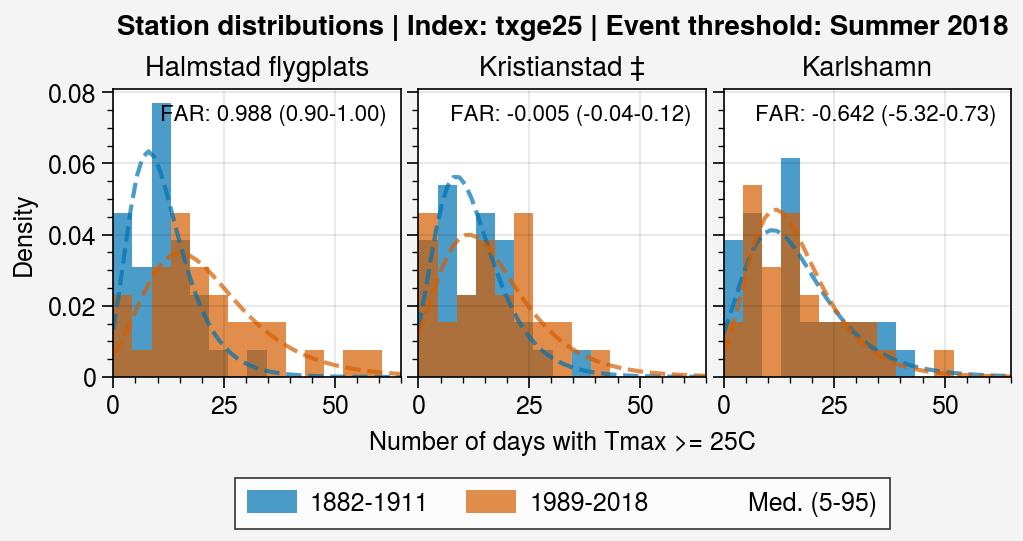

In [136]:
n_cubes = 3
nrows = math.ceil(len(hist_cubes[:n_cubes]) / 3)
fig, axs = pplt.subplots(
    nrows=nrows,
    ncols=3,
    figwidth="13cm",
    # figheight="20cm",
    wspace=0.7,
    sharex="all",
    sharey="all",
)
# axs_to_use = np.concatenate([axs.flat[:1], axs.flat[3:]])
axs_to_use = axs
for hist_cube, curr_cube, far_ci, ax in zip(
    hist_cubes[:n_cubes], curr_cubes[:n_cubes], far_ci_q[:n_cubes], axs_to_use
):
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    ax.hist(hist_data, bins=bins, label="1882-1911", alpha=0.7, density=True)
    ax.hist(curr_data, bins=bins, label="1989-2018", alpha=0.7, density=True)
    dist = dists["gumbel_r"]
    hist_fit, curr_fit = fit_dist(hist_data, curr_data, dist)
    x = np.linspace(bins.min(), bins.max())
    ax.plot(x, dist.pdf(x, *hist_fit), c="C0", alpha=0.7, ls="--")
    ax.plot(x, dist.pdf(x, *curr_fit), c="C1", alpha=0.7, ls="--")

    title = hist_cube.attributes["station_name"]
    hist_check, curr_check = check_station(title)
    if hist_check:
        title += " †"
    if curr_check:
        title += " ‡"
    #
    ax.set_title(title)
    format_string = ".3g" if far_ci[0] < -1e2 else ".2f"
    ax.annotate(
        f"FAR: {far_ci[1]:.3f} ({far_ci[0]:{format_string}}-{far_ci[2]:.2f})",
        (0.95, 0.95),
        xycoords="axes fraction",
        va="top",
        ha="right",
        fontsize=8,
    )

# axs.flat[1].axis("off")
# axs.flat[2].axis("off")


long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
# Legend
axs[0].plot([], [], " ", label="Med. (5-95)")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols=4, loc="b")
axs.format(
    ylabel="Density",
    xlabel=f"{long_name}",
    suptitle=f"Station distributions | Index: {index_name} | Event threshold: {threshold_name}",
)

In [137]:
fig.save(f"../plots/{index_name}_station_distributions_far_pres_sel.pdf", facecolor="none")

## FAR bar plots

In [138]:
# Save bootstrap results.
labels = [cube.attributes["station_name"] for cube in hist_cubes]
df = pd.DataFrame(far_res, index=labels)
df.to_csv(f"./data/res/{index_name}_far_boot.csv")

In [139]:
labels = [cube.attributes["station_name"] for cube in hist_cubes]
far_ci = np.quantile(far_res, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1).T

far_ci = np.concatenate([far_ci, far_ci.mean(axis=0, keepdims=True)])
labels += ["Average"]

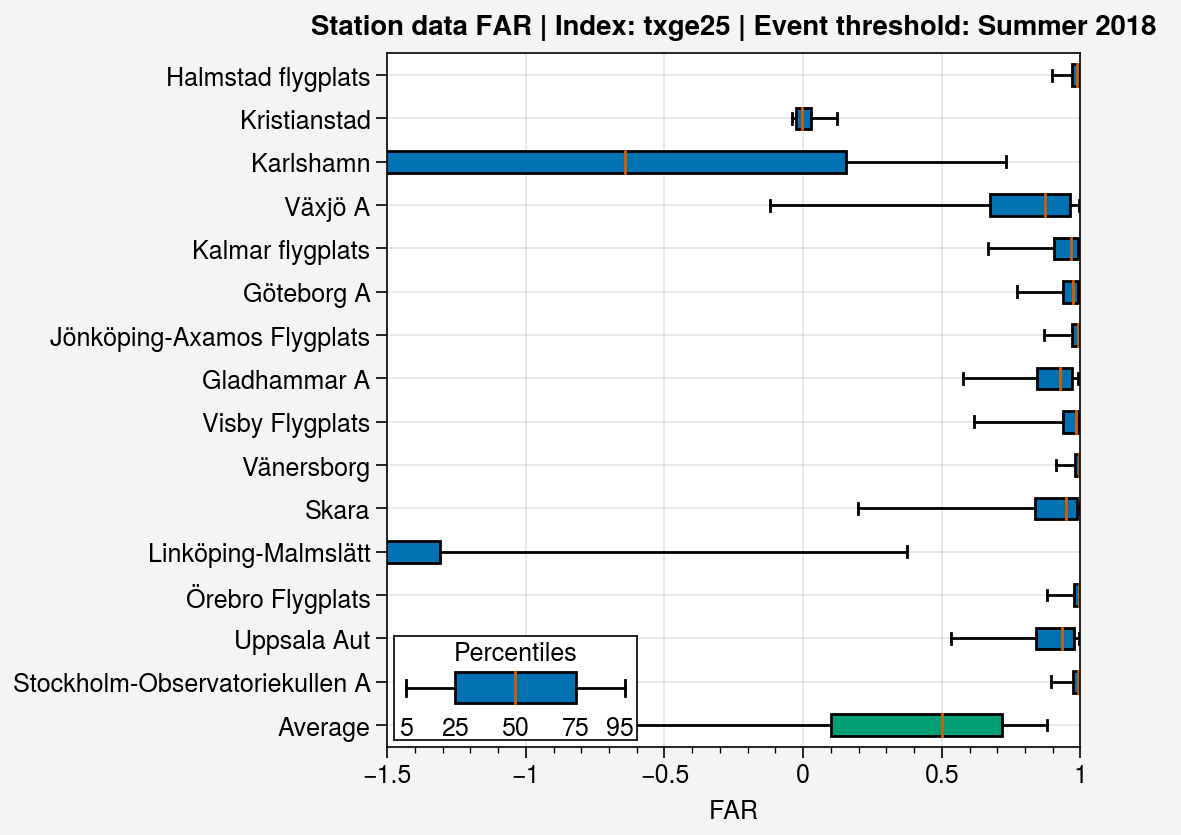

In [141]:
boxes = [
    {
        "label": label,
        "whislo": pbr[0],
        "q1": pbr[1],
        "med": pbr[2],
        "q3": pbr[3],
        "whishi": pbr[4],
        "fliers": None,
    }
    for pbr, label in zip(far_ci, labels)
]
fig, ax = pplt.subplots(
    figwidth="15cm",
)
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.15], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xticks=False,
    yticks=False,
    xlim=(0, 100),
)

# axins.set_facecolor('none')

# Labels
ax.format(
    xlabel="FAR",
    suptitle=f"Station data FAR | Index: {index_name} | Event threshold: {threshold_name}",
    xreverse=False,
    xlim=(-1.5, 1),
    ytickminor=False,
);

In [142]:
fig.save(f"../plots/{index_name}_station_bars_far.pdf")

## Shifting station data

How to do this:

- For each station draw 1000 random realization
- Regress each variant to GMST.
- Fit a distribution to each current realization (This is already done in the current bootstrap).
- Also fit a distribution to each historical realization.
- Shift the dist of the current realization.
- Sample all three dists for the threshold.

In [37]:
from attribution.funcs import shift_dist_params
from attribution.utils import get_gmst

In [38]:
gmst = get_gmst(curr_cubes[0])

In [39]:
def get_regression(data, predictor):
    X = sm.add_constant(predictor)
    # Compute the regression.
    res = sm.OLS(data, X).fit()
    coefs = res.params[-1]
    pvalues = res.pvalues[-1]
    conf_int = res.conf_int()
    return coefs, pvalues, conf_int

In [40]:
rng = np.random.default_rng()

In [143]:
n_stations = len(hist_cubes)
far_res = np.zeros((n_stations, 1000, 2))
for hist_cube, curr_cube, res in tqdm(
    zip(hist_cubes, curr_cubes, far_res), total=n_stations
):
    # dist = attribution.validation.select_distribution(curr_cube.data, dists)
    hist_data = hist_cube.data
    curr_data = curr_cube.data
    fit = dist.fit(curr_data)
    threshold_quantile = dist.sf(curr_data[-1], *fit)
    hist_resampled = rng.choice(hist_data, size=(1000, hist_data.shape[0]))
    curr_resampled = rng.choice(curr_data, size=(1000, hist_data.shape[0]))
    for i, (hist_data_r, curr_data_r) in enumerate(zip(hist_resampled, curr_resampled)):
        coef, pval, _ = get_regression(curr_data_r, gmst)
        hist_fit, curr_fit = fit_dist(hist_data_r, curr_data_r, dists["gumbel_r"])
        hist_fit_shift = shift_dist_params(-1.2, curr_fit, coef)
        threshold = dist.isf(threshold_quantile, *curr_fit)
        res[i, 0] = get_far(hist_fit, curr_fit, threshold, dists["gumbel_r"])
        res[i, 1] = get_far(hist_fit_shift, curr_fit, threshold, dists["gumbel_r"])

  0%|          | 0/15 [00:00<?, ?it/s]

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

In [144]:
far_res_shift_ci = np.quantile(far_res, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1)
far_res_shift_ci = np.moveaxis(far_res_shift_ci, (0, 1, 2), (2, 0, 1))

In [145]:
labels = [cube.attributes["station_name"] for cube in hist_cubes]

In [146]:
threshold_name = "Summer 2018"

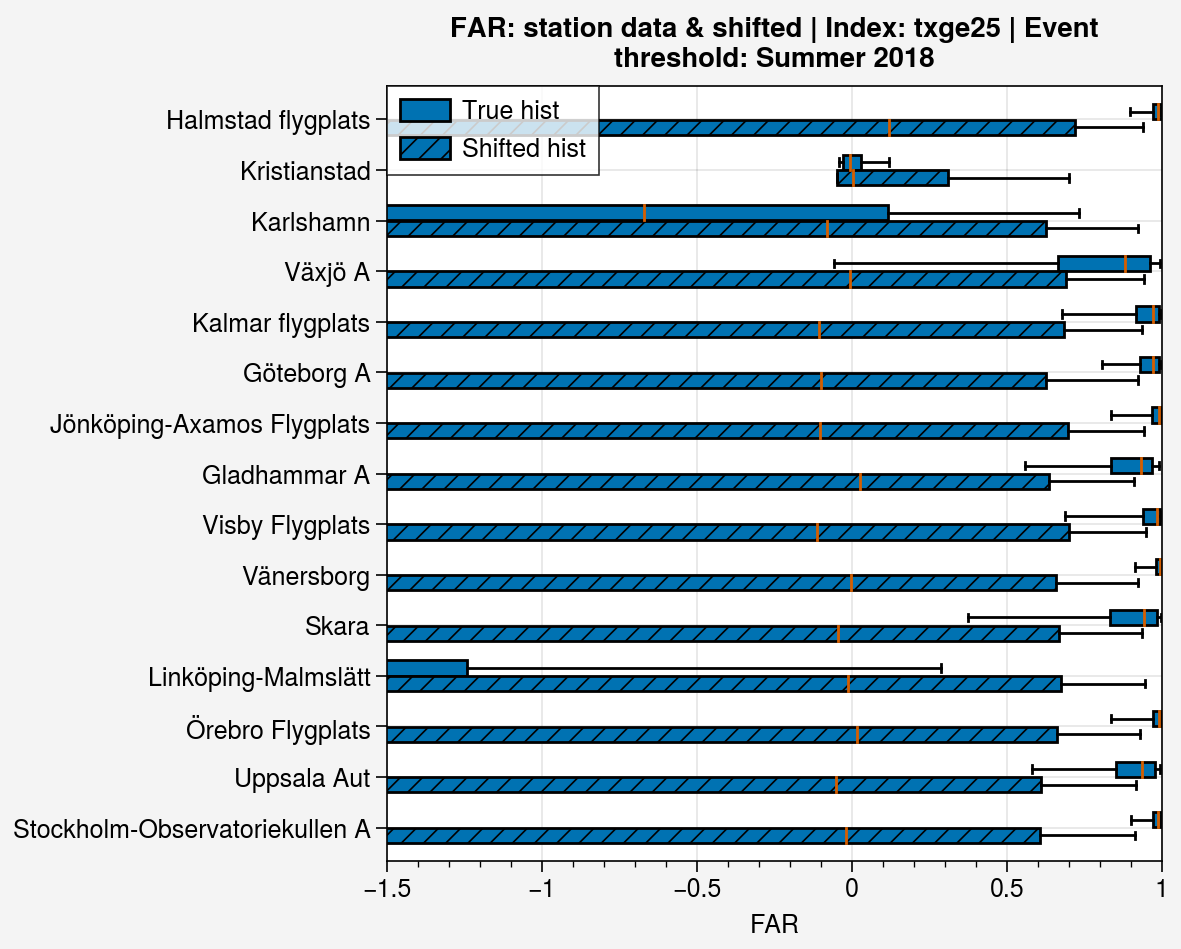

In [148]:
boxes = [
    {
        "label": label,
        "whislo": pbr[0],
        "q1": pbr[1],
        "med": pbr[2],
        "q3": pbr[3],
        "whishi": pbr[4],
        "fliers": None,
    }
    for pbr, label in zip(far_res_shift_ci[:, 0, :], labels)
]
boxes_shift = [
    {
        "label": None,
        "whislo": pbr[0],
        "q1": pbr[1],
        "med": pbr[2],
        "q3": pbr[3],
        "whishi": pbr[4],
        "fliers": None,
    }
    for pbr, label in zip(far_res_shift_ci[:, 1, :], labels)
]
fig, ax = pplt.subplots(
    figwidth="15cm",
)
pos = np.arange(0, 15)
patches = ax.bxp(
    boxes[::-1],
    positions=pos + 0.155,
    widths=0.3,
    vert=False,
    showfliers=False,
    patch_artist=True,
)
# patches["boxes"][0].set_color("C2")
# patches["boxes"][0].set_edgecolor("k")
patches_shift = ax.bxp(
    boxes_shift[::-1],
    positions=pos - 0.155,
    widths=0.3,
    vert=False,
    showfliers=False,
    patch_artist=True,
)
for box in patches_shift["boxes"]:
    box.set_hatch("///")
    # box.set_color("C2")
    # box.set_edgecolor("k")


ax.legend(
    [patches["boxes"][0], patches_shift["boxes"][0]],
    ["True hist", "Shifted hist"],
    ncols=1,
)

# Labels
title = "\n".join(
    wrap(
        f"FAR: station data & shifted | Index: {index_name} | Event threshold: {threshold_name}",
        55,
    )
)
ax.format(
    xlabel="FAR",
    suptitle=title,
    xreverse=False,
    xlim=(-1.5, 1),
    ytickminor=False,
    yticks=pos,
);

In [149]:
fig.save(f"../plots/{index_name}_station_shift_far_bar.pdf")

## Regression map

In [55]:
reg_coefs = []
p_vals = [] 
for curr_cube in tqdm(curr_cubes):
    coef, p_val, _ = get_regression(curr_cube.data, gmst)
    reg_coefs.append(coef)
    p_vals.append(p_val)

  0%|          | 0/15 [00:00<?, ?it/s]

In [81]:
from textwrap import wrap

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/matplotlib/collections.py:1114: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


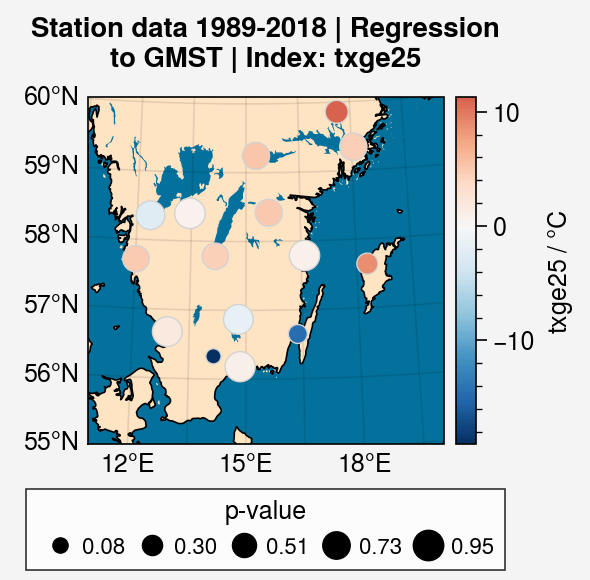

In [89]:
def normalise_inv(s, spread, smin, smax):
    return ((s - smin) / (smax-smin)) * np.ptp(spread) + np.min(spread)


fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))

annotations = []
lats = []
lons = []
for cube in curr_cubes:
    lats.append(cube.coord("latitude").cell(0).point)
    lons.append(cube.coord("longitude").cell(0).point)

smin = 30
smax = 120
sizes = ((smax-smin)*(p_vals - np.min(p_vals))/np.ptp(p_vals)) + smin
sc = ax.scatter(
    lons,
    lats,
    c=reg_coefs,
    s=sizes,
    absolute_size=True,
    # smin=smin,
    # smax=smax,
    vmax=max(reg_coefs),
    vmin=min(reg_coefs),
    # extend="min",
    zorder=3,
    edgecolor="lightgray",
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
)

ax.colorbar(sc, label="txge25 / $\degree$C", width="0.25cm")

handles, labels = sc.legend_elements(
    "sizes",
    num=np.histogram_bin_edges(p_vals, 4),
    fmt="{x:.2f}",
    func=lambda x: normalise_inv(x, p_vals, smin, smax)
)
ax.legend(
    handles,
    labels,
    title="p-value",
    # loc="lower right",
    loc="b",
    ncols=5,
    handletextpad=0.01,
    columnspacing=0.2,
    fontsize=8,
)
first_year = curr_cube.coord("time").cell(0).point.year
last_year = curr_cube.coord("time").cell(-1).point.year
title = f"Station data {first_year}-{last_year} | Regression to GMST | Index: {index_name}"
title = "\n".join(wrap(title, 35))
ax.format(
    coast=True,
    land=True,
    lakes=True,
    lakescolor="ocean blue",
    facecolor="ocean blue",
    landcolor="bisque",
    reso="hi",
    lonlim=(11, 20),
    latlim=(55, 60),
    lonlabels=True,
    latlabels="l",
    suptitle=title
)

In [90]:
fig.save(f"../plots/{index_name}_station_regression_map.pdf")

## Trends

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the r

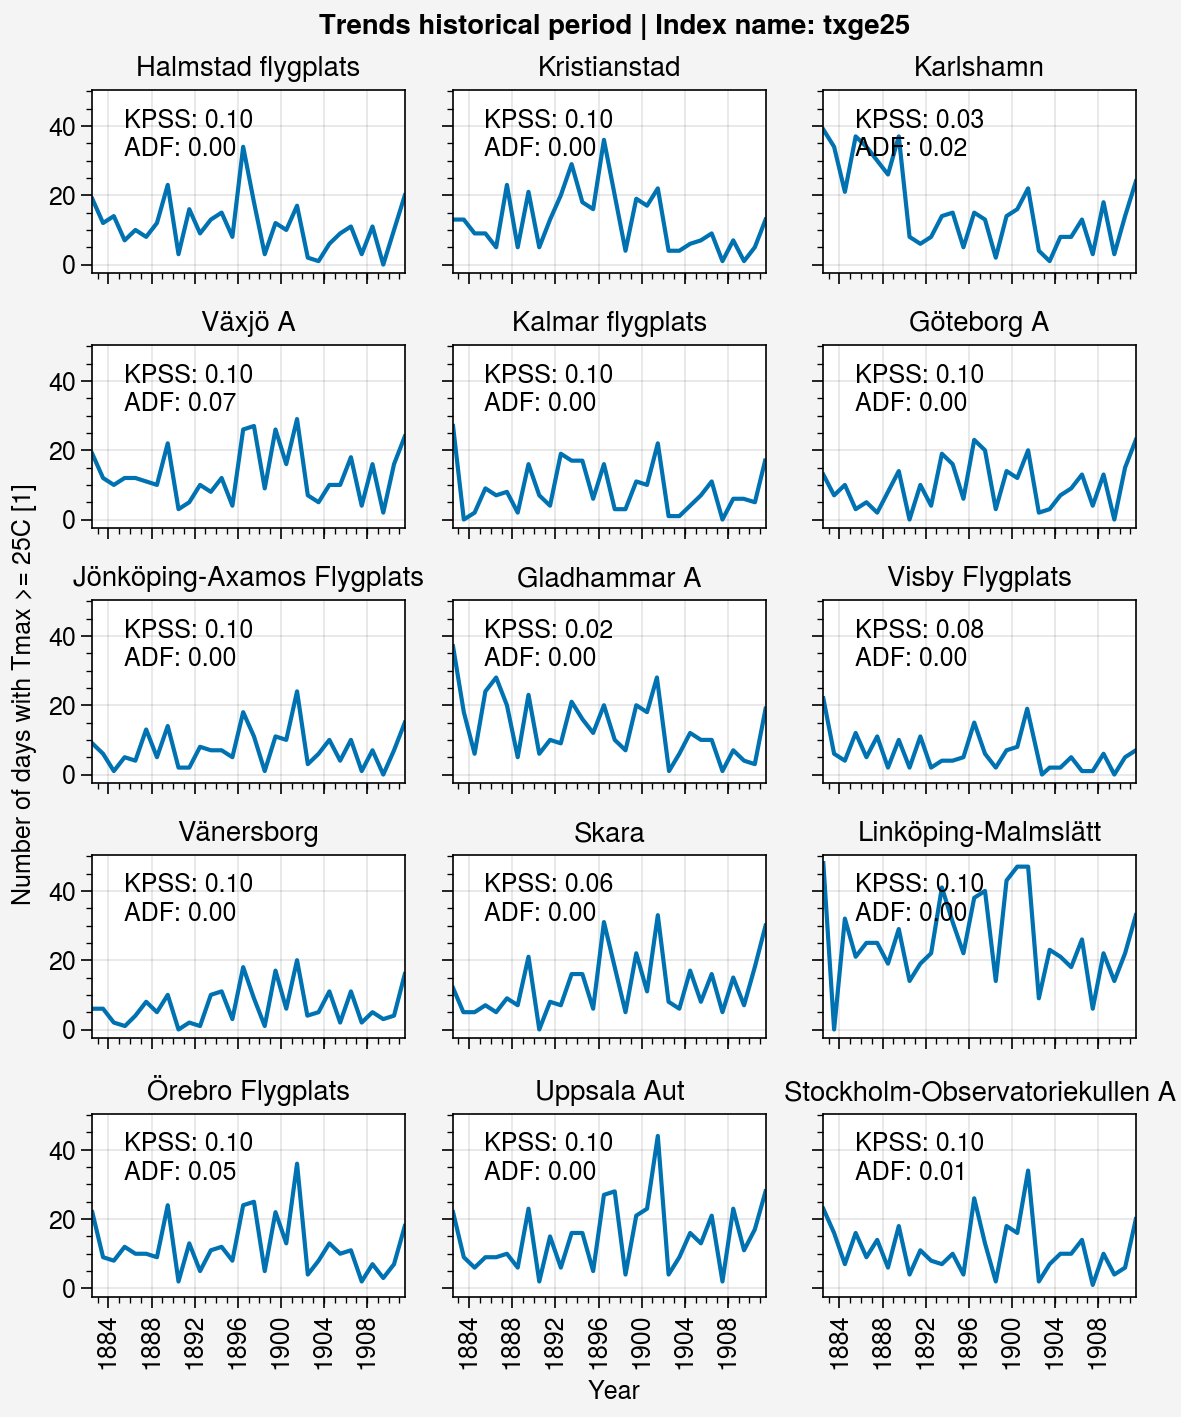

In [56]:
fig, axs = pplt.subplots(
    nrows=5, ncols=3, figwidth="15cm", figheight="18cm", share="all"
)
for ax, cube in zip(axs, hist_cubes):
    iplt.plot(cube, axes=ax, label=".")
    ax.format(title=cube.attributes["station_name"])

    kpss = smt.stattools.kpss(cube.data)
    adf = smt.stattools.adfuller(cube.data)
    ax.annotate(
        f"KPSS: {kpss[1]:.2f}\nADF: {adf[1]:.2f}",
        (0.1, 0.9),
        xycoords="axes fraction",
        ha="left",
        va="top",
    )
long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
axs.format(xlabel="Year", ylabel=f"{long_name} [{unit}]")
fig.format(suptitle=f"Trends historical period | Index name: {index_name}")

In [172]:
fig.save(f"../plots/trend_hist_{index_name}.pdf")

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the r

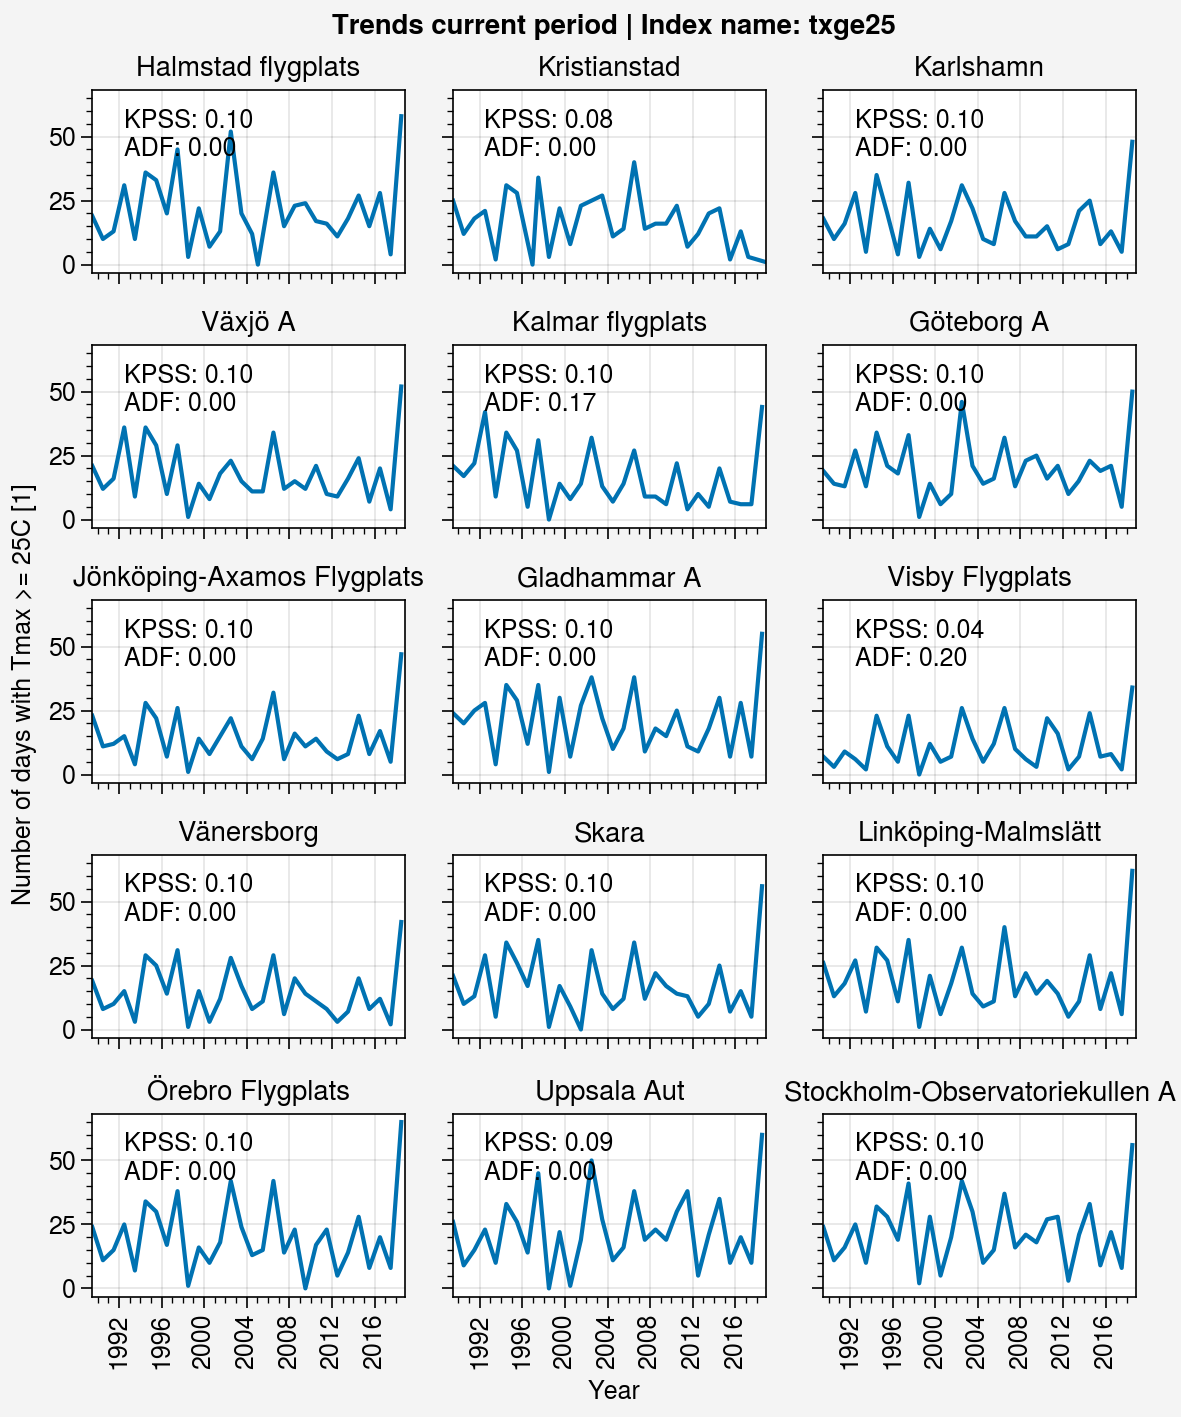

In [53]:
fig, axs = pplt.subplots(
    nrows=5, ncols=3, figwidth="15cm", figheight="18cm", share="all"
)
for ax, cube in zip(axs, curr_cubes):
    iplt.plot(cube, axes=ax, label=".")
    ax.format(title=cube.attributes["station_name"])

    kpss = smt.stattools.kpss(cube.data)
    adf = smt.stattools.adfuller(cube.data)
    ax.annotate(
        f"KPSS: {kpss[1]:.2f}\nADF: {adf[1]:.2f}",
        (0.1, 0.9),
        xycoords="axes fraction",
        ha="left",
        va="top",
    )
long_name = hist_cubes[0].long_name
unit = hist_cubes[0].units
axs.format(xlabel="Year", ylabel=f"{long_name} [{unit}]")
fig.format(suptitle=f"Trends current period | Index name: {index_name}")

In [174]:
fig.save(f"../plots/trend_curr_{index_name}.pdf")